In [3]:
import numpy as np
import math
import torch
from torch import nn
from torch.nn import Parameter
from torch.nn import functional as F
import matplotlib.pyplot as plt

from process_data import data, train_data, test_data, item_set
from process_data import TrainDataset, MyDataset, get_dataloader

import warnings
warnings.filterwarnings("ignore")

# 一、构建session graph

建立邻接矩阵$\mathbf{A}$，包括$\mathbf{A}^{(in)}$和$\mathbf{A}^{(out)}$

In [5]:
def get_slice(item_seq, device):
    """
    获取alias_inputs, A, items, mask
    """
    # Mask matrix, shape = [batch_size, max_seq_len]
    mask = item_seq.gt(0)  # > 0的元素

    max_n_node = item_seq.size(1)
    items, A, alias_inputs = [], [], []
    item_seq = item_seq.cpu().numpy()

    # === 构造邻接矩阵A ===
    for u_input in item_seq:
        # 将该session去重，并由大到小排序
        node = np.unique(u_input)
        # 以0填补后加入items列表
        items.append(node.tolist() + (max_n_node - len(node)) * [0])

        # 构造A（不区分in和out）
        u_A = np.zeros((max_n_node, max_n_node))
        for i in np.arange(len(u_input) - 1):
            if u_input[i + 1] == 0:  # 是该session的最后一个item
                break
            u = np.where(node == u_input[i])[0][0]
            v = np.where(node == u_input[i + 1])[0][0]
            u_A[u][v] = 1

        # A^in
        u_sum_in = np.sum(u_A, 0)
        u_sum_in[np.where(u_sum_in == 0)] = 1
        u_A_in = np.divide(u_A, u_sum_in)  # 归一化

        # A^out
        u_sum_out = np.sum(u_A, 1)
        u_sum_out[np.where(u_sum_out == 0)] = 1
        u_A_out = np.divide(u_A.transpose(), u_sum_out)  # 归一化

        # A
        u_A = np.concatenate([u_A_in, u_A_out]).transpose()
        A.append(u_A)

        alias_inputs.append([np.where(node == i)[0][0] for i in u_input])

    # The relative coordinates of the item node, shape = [batch_size, max_seq_len]
    alias_inputs = torch.LongTensor(alias_inputs).to(device)

    # The connection matrix, shape = [batch_size, max_seq_len, 2 * max_seq_len]
    A = torch.FloatTensor(A).to(device)

    # The unique item nodes, shape = [batch_size, max_seq_len]
    items = torch.LongTensor(items).to(device)

    return alias_inputs, A, items, mask

# 二、搭建模型

## GGNN

\begin{align}
\mathbf{a}^t_{s, t} &= \mathbf{A}_{s, i:}\begin{bmatrix}\mathbf{v}^{t-1}_1, ..., \mathbf{v}^{t-1}_n \end{bmatrix}^T \mathbf{H} + \mathbf{b} \tag{1} \\
\mathbf{z}^t_{s,i} &= \sigma(\mathbf{W}_z \mathbf{a}^t_{s, i} + \mathbf{U}_z \mathbf{v}^{t-1}_i) \tag{2} \\
\mathbf{r}^t_{s,i} &= \sigma(\mathbf{W}_r \mathbf{a}^t_{s, i} + \mathbf{U}_r \mathbf{v}^{t-1}_i) \tag{3} \\
\tilde{\mathbf{v}}^t_i &= \text{tanh}(\mathbf{W}_o \mathbf{a}^t_{s, i} + \mathbf{U}_o (\mathbf{r}^t_{s,i} \odot \mathbf{v}^{t-1}_i)) \tag{4} \\
\mathbf{v}^t_i &= (1-\mathbf{z}^t_{s,i}) \odot \mathbf{v}^{t-1}_{i} + \mathbf{z}^t_{s,i} \odot \tilde{\mathbf{v}}^t_i \tag{5}
\end{align}

In [6]:
class GGNN(nn.Module):

    def __init__(self, embedding_size, step=1):
        super(GGNN, self).__init__()
        self.step = step  # GNN层数
        self.embedding_size = embedding_size
        self.input_size = embedding_size * 2
        self.gate_size = embedding_size * 3

        # hidden层参数
        self.w_ih = Parameter(torch.Tensor(self.gate_size, self.input_size))
        self.w_hh = Parameter(torch.Tensor(self.gate_size, self.embedding_size))
        self.b_ih = Parameter(torch.Tensor(self.gate_size))
        self.b_hh = Parameter(torch.Tensor(self.gate_size))
        self.b_iah = Parameter(torch.Tensor(self.embedding_size))
        self.b_ioh = Parameter(torch.Tensor(self.embedding_size))

        # 矩阵 H 对应的线性变换
        self.linear_edge_in = nn.Linear(self.embedding_size, self.embedding_size)
        self.linear_edge_out = nn.Linear(self.embedding_size, self.embedding_size)

    def GGNNCell(self, A, hidden):
        """
        用GNN学习item embedding

        Params:
            A(torch.FloatTensor): 邻接矩阵, shape = [batch_size, max_session_len, 2 * max_session_len]
            hidden(torch.FloatTensor): 矩阵[v_i], shape = [batch_size, max_session_len, embedding_size]

        Returns:
            v: node embedding矩阵, shape = [batch_size, max_session_len, embedding_size]
        """

        # === 公式(1) ===
        max_len = A.size(1)
        H_in = self.linear_edge_in(hidden)
        H_out = self.linear_edge_out(hidden)
        input_in = torch.matmul(A[:, :, : max_len], H_in) + self.b_iah
        input_out = torch.matmul(A[:, :, max_len: 2*max_len], H_out) + self.b_ioh
        # shape = [batch_size, max_session_len, embedding_size * 2]
        mat_a = torch.cat([input_in, input_out], 2)

        # shape = [batch_size, max_session_len, embedding_size * 3]
        Wa = F.linear(mat_a, self.w_ih, self.b_ih)  # W·[a]
        Uv = F.linear(hidden, self.w_hh, self.b_hh)  # U·[v]
        # shape = (batch_size, max_session_len, embedding_size)
        Wza, Wra, Woa = Wa.chunk(3, 2)
        Uzv, Urv, Uov = Uv.chunk(3, 2)

        # === 公式(2)和(3) ===
        gate_r = torch.sigmoid(Wra + Urv)  # update gate
        gate_z = torch.sigmoid(Wza + Uzv)  # reset gate

        # === 公式(4) ===
        candidate = torch.tanh(Woa + gate_r * Uov)

        # === 公式(5) ===
        v = (1 - gate_z) * hidden + gate_z * candidate
        return v

    def forward(self, A, hidden):
        for i in range(self.step):
            hidden = self.GGNNCell(A, hidden)
        return hidden

## SR-GNN

$$ \mathbf{s}_l = \mathbf{v}_n \\ $$

\begin{align}
\alpha_i &= \mathbf{q}^T \cdot \sigma(\mathbf{W}_1\mathbf{v}_n + \mathbf{W}_2\mathbf{v}_i + \mathbf{c}) \\
\mathbf{s}_g &= \sum_{i=1}^n \alpha_i \mathbf{v}_i \tag{6} 
\end{align}

\begin{align}
\mathbf{s}_h = \mathbf{W}_3 [\mathbf{s}_l, \mathbf{s}_g] \tag{7} 
\end{align}

\begin{align}
\mathbf{\hat{z}}_i = \mathbf{s}_h^T \mathbf{v}_i \tag{8} 
\end{align}

$$ \mathbf{\hat{y}} = \text{softmax}(\mathbf{z}) \in \mathbb{R}^m $$

In [7]:
class SRGNN(nn.Module):

    def __init__(self, item_size, embedding_size, step, device):
        super(SRGNN, self).__init__()

        # === 定义参数 ===
        self.embedding_size = embedding_size
        self.step = step
        self.n_items = item_size
        self.device = device

        # === 定义layers ===
        # item embedding, 将session映射到embedding空间
        self.item_embedding = nn.Embedding(self.n_items, self.embedding_size, padding_idx=0)
        # layers
        self.gnn = GGNN(self.embedding_size, self.step)
        self.W1 = nn.Linear(self.embedding_size, self.embedding_size)  # W1
        self.W2 = nn.Linear(self.embedding_size, self.embedding_size)  # W2
        self.q = nn.Linear(self.embedding_size, 1, bias=False)  # q'
        self.W3 = nn.Linear(self.embedding_size * 2, self.embedding_size)  # W3

        # === 初始化参数 ===
        self._reset_parameters()

    def _reset_parameters(self):
        stdv = 1.0 / math.sqrt(self.embedding_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)

    def forward(self, item_seq, seq_len):
        alias_inputs, A, items, mask = get_slice(item_seq, self.device)

        # === 公式(1)~(5)，得到item vector v ===
        hidden = self.item_embedding(items)
        hidden = self.gnn(A, hidden)
        alias_inputs = alias_inputs.view(-1, alias_inputs.size(1), 1).expand(-1, -1, self.embedding_size)
        v = torch.gather(hidden, dim=1, index=alias_inputs)  # v of X, [bs, seq_len, emb_size]

        # === 最后一个hidden state sl = vn ===
        batchsize = mask.shape[0]
        dim0_idx = torch.arange(batchsize).long()
        dim1_idx = torch.sum(mask, 1) - 1
        sl = v[dim0_idx, dim1_idx]

        # === attention ===
        q1 = self.W1(sl).view(sl.size(0), 1, sl.size(1))
        q2 = self.W2(v)
        alpha = self.q(torch.sigmoid(q1 + q2)).expand_as(v)  # [bs, seq_len, emb_size]
        # sg = alpha * v
        mask = mask.unsqueeze(2).expand_as(v).float()  # [bs, seq_len, emb_size]
        sg = alpha * v * mask  # [bs, seq_len, emb_size]

        # === concatenate ===
        sh = self.W3(torch.cat([sg, v], dim=2))  # [bs, seq_len, emb_size]
        # 映射回item_size空间
        scores = sh @ self.item_embedding.weight.T  # [bs, seq_len, n_item]

        return scores

    def predict(self, item_seq):
        self.eval()
        with torch.no_grad():
            scores = self.forward(item_seq, item_seq.shape[1])  # [bs, seq_len, emb_size]
        self.train()
        scores = scores[:, -1, :]  # 取最后一个timestep，[bs, item_size]
        return scores

# 三、模型训练

## 评价指标

In [8]:
def test_HR_MRR(model, test_dataset, k=20):
    count = 0
    score = 0
    for X, y in test_dataset:
        X = torch.tensor(X, dtype=torch.long).to(device)
        X = X.unsqueeze(0)  # [1, seq_len]

        # 预测，获取Top-K items列表
        output = model.predict(X).cpu().detach()  # [1, item_size]
        output = output.squeeze(0)  # [item_size]
        top_k = output.topk(k).indices.numpy()

        if y in top_k:
            # HR
            count += 1
            # MRR
            rank_y = np.where(top_k == y)[0][0] + 1
            score += 1 / rank_y

    HR = count / len(test_dataset)
    MRR = score / len(test_dataset)

    return HR, MRR

## 1. 模型训练设置

定义了SRGNN的`ModelTrain`类，打包训练过程

In [9]:
class ModelTrain:
    def __init__(self, model, dataset, train_loader, test_loader, optimizer, loss_func, n_epoch):
        self.model = model
        self.train_dataset = dataset[0]
        self.test_dataset = dataset[1]
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.optimizer = optimizer
        self.loss_func = loss_func
        self.n_epoch = n_epoch

        # 记录loss
        self.train_losses = []
        # 记录test上的准确率
        self.test_acc = []

    def _train_one_epoch(self, epoch):
        train_loss = 0.0
        for batch_idx, batch in enumerate(self.train_loader):
            # 获取batch数据
            X = batch[0].to(device)  # [bs, seq_len]
            y = batch[1].to(device)  # [bs]

            # 模型预测
            scores = self.model(X, X.shape[1])  # [bs, seq_len, item_size]
            scores = scores.reshape(-1, scores.shape[-1])  # [bs*seq_len, n_item]
            loss = self.loss_func(scores, y.flatten())
            train_loss += loss.item()

            # 反向传播，更新参数
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        if epoch % 20 == 0:
            print(f"\nepoch {epoch} ......")
            print(f"train loss = {train_loss:.2f}")
        self.train_losses.append(train_loss)

    def _test_one_epoch(self):
        acc = 0
        batch_idx = 0
        for batch_idx, batch in enumerate(self.test_loader):
            X = batch[0].to(device)
            y = batch[1].to(device)  # [bs]
            pred = self.model.predict(X)  # [bs, n_item]
            pred = pred.argmax(1).cpu()  # [bs]
            acc += np.sum(pred.numpy() == y.cpu().numpy()) / pred.shape[0]
        acc /= (batch_idx + 1)
        print(f"test accuracy = {acc:.2f}")
        self.test_acc.append(acc)

        # 计算评价指标
        hit_ratio, MRR = test_HR_MRR(self.model, self.test_dataset)
        print(f"MRR = {MRR:.4f} | HR = {hit_ratio:.4%}")

    def train(self, test=False):
        # 记录清零
        self.train_losses = []
        self.test_acc = []
        # 训练
        self.model.train()
        for e in range(self.n_epoch):
            self._train_one_epoch(e)

            # 在test上进行测试，包括accuracy和评价指标的计算
            if e % 20 == 0 and test:
                self.model.eval()
                with torch.no_grad():
                    self._test_one_epoch()
                self.model.train()

    def get_info(self):
        losses = {'train_losses': self.train_losses,
                  'test_acc': self.test_acc}
        return losses

    def plot_train_loss(self):
        plt.figure()
        plt.plot(self.train_losses)
        plt.ylabel('train loss')
        plt.xlabel('epoch')
        plt.show()

    def plot_test_acc(self):
        plt.figure()
        plt.plot(self.test_acc)
        plt.ylabel('test accuracy')
        plt.xlabel('epoch')
        plt.show()

    def plot_performance(self):
        fig = plt.figure(figsize=(14, 5))

        ax = fig.add_subplot(121)
        ax.plot(self.train_losses)
        ax.set_ylabel('train_loss')
        ax.set_xlabel('epoch')
        ax.set_title("train loss change with epoch")

        ax = fig.add_subplot(122)
        ax.plot([i * 20 for i in range(1, len(self.test_acc)+1)], self.test_acc)
        ax.set_ylabel('test_accuracy')
        ax.set_xlabel('epoch')
        ax.set_title("test accuracy change per 20 epoches")

        plt.show()

## 2. 超参数设置

In [15]:
num_epoch = 101
batch_size = 256
lr = 0.01
embedding_size = 100
hidden_size = 128
item_size = len(item_set) + 1  # +1是因为做了零填充，相当于增加了一个item '0'
output_size = item_size
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
# 数据
train_dataset = TrainDataset(train_data)
test_dataset = MyDataset(test_data)
print(len(train_dataset), len(test_dataset))

train_loader = get_dataloader(batch_size, dataset=train_dataset, train=True)
test_loader = get_dataloader(batch_size, dataset=test_dataset, train=False)

18055 4514


## 3. 训练和测试

lr = 0.01, batch_size = 256

In [16]:
model = SRGNN(item_size=item_size,
              embedding_size=embedding_size,
              step=1,
              device=device).to(device)

train = ModelTrain(model=model,
                   dataset=(train_dataset, test_dataset),
                   train_loader=train_loader,
                   test_loader=test_loader,
                   optimizer=torch.optim.Adam(model.parameters(), lr=lr),
                   loss_func=nn.CrossEntropyLoss(),
                   n_epoch=num_epoch)

train.train(test=True)


epoch 0 ......
train loss = 433.92
test accuracy = 0.03
MRR = 0.0473 | HR = 10.3899%

epoch 20 ......
train loss = 21.73
test accuracy = 0.04
MRR = 0.0680 | HR = 13.1591%

epoch 40 ......
train loss = 29.55
test accuracy = 0.05
MRR = 0.0712 | HR = 13.9566%

epoch 60 ......
train loss = 8.41
test accuracy = 0.05
MRR = 0.0759 | HR = 14.9535%

epoch 80 ......
train loss = 19.61
test accuracy = 0.05
MRR = 0.0764 | HR = 14.4883%

epoch 100 ......
train loss = 9.19
test accuracy = 0.05
MRR = 0.0775 | HR = 14.9313%


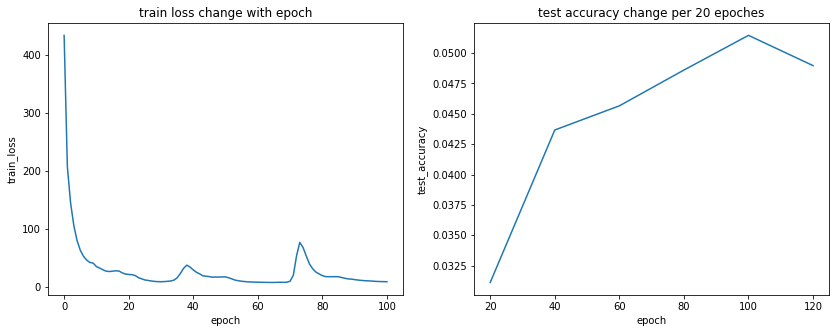

In [18]:
train.plot_performance()

lr = 0.005, batch_size = 256

In [19]:
model = SRGNN(item_size=item_size,
              embedding_size=embedding_size,
              step=1,
              device=device).to(device)

train = ModelTrain(model=model,
                   dataset=(train_dataset, test_dataset),
                   train_loader=train_loader,
                   test_loader=test_loader,
                   optimizer=torch.optim.Adam(model.parameters(), lr=0.005),
                   loss_func=nn.CrossEntropyLoss(),
                   n_epoch=num_epoch)

train.train(test=True)


epoch 0 ......
train loss = 465.71
test accuracy = 0.02
MRR = 0.0376 | HR = 8.4183%

epoch 20 ......
train loss = 13.15
test accuracy = 0.05
MRR = 0.0796 | HR = 15.0642%

epoch 40 ......
train loss = 12.29
test accuracy = 0.05
MRR = 0.0725 | HR = 13.4471%

epoch 60 ......
train loss = 6.10
test accuracy = 0.05
MRR = 0.0761 | HR = 14.2003%

epoch 80 ......
train loss = 7.65
test accuracy = 0.05
MRR = 0.0712 | HR = 13.1369%

epoch 100 ......
train loss = 6.00
test accuracy = 0.05
MRR = 0.0743 | HR = 13.8458%


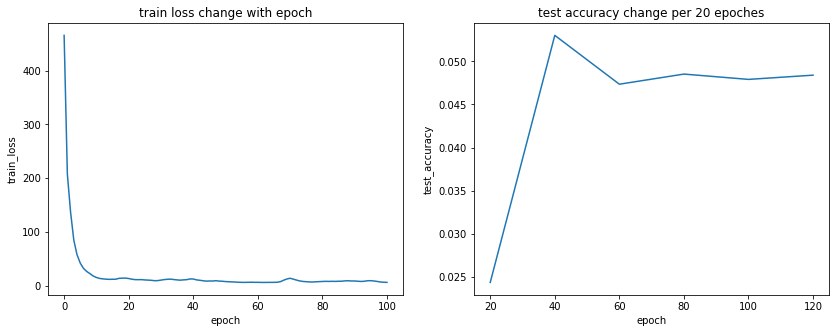

In [20]:
train.plot_performance()

lr = 0.01, batch_size = 256